# Reproduction of the paper of Weitz et al.

### Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

### Figure 1

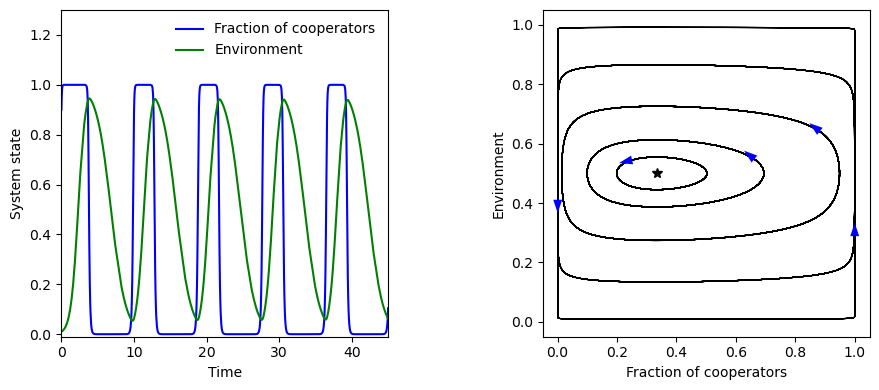

In [166]:
def dynamics_symmetric(t, y, epsilon, theta, R, S, T, P):
    """System dynamics for the symmetric case (Eq. 17)."""
    x, n = y
    delta_PS = P - S
    delta_TR = T - R
    
    # Fitness difference term
    payoff_term = (1.0 - 2.0 * n) * (delta_PS + (delta_TR - delta_PS) * x)
    
    dxdt = (1.0 / epsilon) * x * (1.0 - x) * payoff_term
    dndt = n * (1.0 - n) * (-1.0 + (1.0 + theta) * x)
    return [dxdt, dndt]

def reproduce_figure_2():
    """Reproduces Figure 2: Symmetric Case."""
    
    # [cite_start]Parameters [cite: 199]
    epsilon = 0.1
    theta = 2.0
    R, S, T, P = 3.0, 0.0, 5.0, 1.0
    
    # Setup Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- LEFT PANEL: Time Series ---
    # [cite_start]Initial condition (0.9, 0.01) [cite: 201]
    y0 = [0.9, 0.01]
    t_span = (0, 45)
    sol = solve_ivp(dynamics_symmetric, t_span, y0, args=(epsilon, theta, R, S, T, P), rtol=1e-5, atol=1e-7)
    
    ax = axes[0]
    ax.plot(sol.t, sol.y[0], color="blue", label='Fraction of cooperators')
    ax.plot(sol.t, sol.y[1], color="green", label='Environment')
    ax.set_xlabel('Time')
    ax.set_ylabel('System state')
    ax.set_xlim(0, 45)
    ax.set_ylim(-0.01, 1.3)
    ax.set_xticks([0, 10, 20, 30, 40])
    ax.set_box_aspect(1)
    ax.legend(loc='upper right', frameon=False, fontsize=10)
    
    # --- RIGHT PANEL: Phase Plane ---
    ax = axes[1]
    
    # [cite_start]Plot Multiple Orbits [cite: 201]
    initial_conditions = [
        (0.9, 0.01), (0.8, 0.15), (0.7, 0.3), (0.5, 0.4), (0.4, 0.45)
    ]
    
    for ic in initial_conditions:
        sol_orbit = solve_ivp(dynamics_symmetric, (0, 100), ic, 
                              args=(epsilon, theta, R, S, T, P),
                              rtol=1e-7, atol=1e-9, max_step=0.05)
        ax.plot(sol_orbit.y[0], sol_orbit.y[1], 'k-', lw=0.8)
        
        # Add directional arrows
        # Sample a point in the middle of the orbit for the arrow
        idx = len(sol_orbit.t) // 6
        x_arr, n_arr = sol_orbit.y[0][idx], sol_orbit.y[1][idx]
        dx, dn = dynamics_symmetric(0, [x_arr, n_arr], epsilon, theta, R, S, T, P)
        
        # Normalize arrow vector
        norm = np.hypot(dx, dn)
        ax.arrow(x_arr, n_arr, dx/norm*0.01, dn/norm*0.01, 
                 shape='full', lw=0, length_includes_head=False, 
                 head_width=0.03, color='blue', zorder=5)

    # [cite_start]Plot Interior Fixed Point (Asterisk) [cite: 203]
    # x* = 1/(1+theta) = 1/3, n* = 0.5
    ax.plot(1.0/(1.0+theta), 0.5, 'k*', markersize=7)
    
    ax.set_xlabel('Fraction of cooperators')
    ax.set_ylabel('Environment')
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_box_aspect(1)
    
    plt.tight_layout()
    plt.show()

reproduce_figure_2()